In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import scipy.constants
import random

In [10]:
class ParticleChain:
    def __init__(self, numpt, potfun, potder, dt, gamma, T, eqmL=1):
        # Initial conditions
        self.x0 = NotImplemented
        self.v0 = NotImplemented
        self.a0 = NotImplemented
        self.iter = -1 # So that the storage index is intuitive
        
        # parameters
        self.numpt = numpt
        self.eqmL = eqmL
        self.potfun = potfun
        self.potder = potder
        self.dt = dt
        self.gamma = gamma
        self.T = T
        
        # Properties
        self.x = NotImplemented
        self.v = NotImplemented
        self.a = NotImplemented
        self.ke = NotImplemented
        self.pe = NotImplemented
        self.etot = NotImplemented
        
        # Scratch variable for Verlet
        self.x_old = NotImplemented
        self.x_half = NotImplemented
        self.v_half = NotImplemented
        
        # Data storage
        self.ke_traj = NotImplemented
        self.pe_traj = NotImplemented
        self.etot_traj = NotImplemented
        
        self.initialise()
        
    def initialise(self):
        if self.iter != -1:
            raise RuntimeError("Particle.initialise() called after instantiation")
        else:
            self.ke_traj = []
            self.pe_traj = []
            self.etot_traj = []

            self.x = np.array([i for i in np.linspace(0, self.eqmL*(self.numpt-1), self.numpt)])
            self.x0 = np.copy(self.x)
            self.v = np.random.rand(self.numpt)
            self.v -= np.average(self.v) # zero the CoM motion
            self.v0 = np.copy(self.v)
            self.a = np.zeros(self.numpt)
            pairWiseDist = (self.x[:-1] - self.x[1:]) + self.eqmL # this is defined for [0:N-1]
            self.forceEval(pairWiseDist)
            self.energyEval(pairWiseDist)
            self.updateTraj()
            self.a0 = np.copy(self.a) # So that the complete set of initial conditions is available
            self.iter += 1
    
    def integrator_old(self):
        # Vanilla Verlet
        if self.iter == 0:
            # first Verlet iteration has to be Euler
            self.x_old = self.x + self.v * self.dt
            self.efEval()
            self.iter += 1
            self.updateTraj()
        
        x_new = 2*self.x - self.x_old + self.a*(self.dt**2)
        self.v = (x_new - self.x_old)/(2*self.dt)
        self.x_old = np.copy(self.x)
        self.x = np.copy(x_new)
        self.efEval()
        self.updateTraj()
        self.iter += 1
                
    def energyEval(self, pwd):
        # energy and force evaluated together as intermediates can be reused 
        self.ke = (0.5*(self.v)**2).sum()        
        self.pe = np.array(list(map(self.potfun, pwd))).sum()
        self.etot = self.ke + self.pe
        
    def forceEval(self,pwd):
        self.a[0] = -self.potder(pwd[0]) # negative derivative is positive force
        self.a[-1] = self.potder(pwd[-1]) # positive derivative is negative force
        self.a[1:-1] = [-self.potder(pwd[i])+self.potder(pwd[i-1]) for i in range(1,self.numpt-1)]
    
    def updateTraj(self):
        self.ke_traj.append(self.ke)
        self.pe_traj.append(self.pe)
        self.etot_traj.append(self.etot)

    def takeStep(self, maxIter):
        while self.iter < maxIter:
            self.integrator()
    
    def reset(self):
        self.iter = -1
        self.initialise()

In [6]:
chain1 = ParticleChain(100, potfun, potder, 0.02)

TypeError: __init__() missing 2 required positional arguments: 'gamma' and 'T'

In [203]:
chain1.reset()
chain1.takeStep(5000)

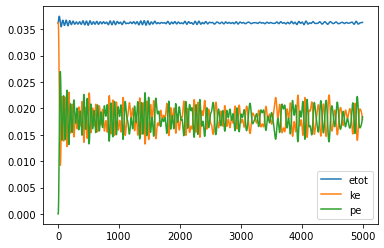

In [204]:
plt.plot(chain1.etot_traj)
plt.plot(chain1.ke_traj)
plt.plot(chain1.pe_traj)
plt.legend(['etot','ke','pe'])

In [11]:
chain2 = ParticleChain(100, potfun, potder, 0.02, 0.01, 0.01)

In [14]:
chain2.reset()
chain2.takeStep(100000)


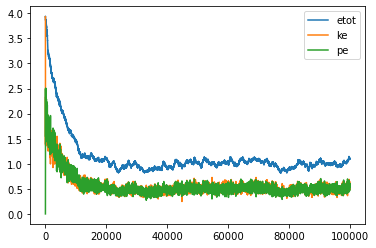

In [15]:
plt.plot(chain2.etot_traj)
plt.plot(chain2.ke_traj)
plt.plot(chain2.pe_traj)
plt.legend(['etot','ke','pe'])

In [17]:
v_abs = np.abs(chain2.v)

In [18]:
v_abs

array([0.064009  , 0.04878805, 0.16963662, 0.05594264, 0.13407433,
       0.06615634, 0.01442525, 0.15660362, 0.0126826 , 0.18793455,
       0.07497803, 0.01951502, 0.1089957 , 0.10183102, 0.03104171,
       0.0123059 , 0.06736417, 0.1218847 , 0.21100297, 0.03847302,
       0.07821281, 0.02734028, 0.02452888, 0.11629246, 0.24773121,
       0.01483571, 0.08051636, 0.03515321, 0.05040901, 0.08612608,
       0.09571296, 0.15064538, 0.05841728, 0.08083349, 0.00353412,
       0.01211628, 0.03180917, 0.05406711, 0.14202562, 0.06001059,
       0.11332295, 0.00079324, 0.05893654, 0.02473969, 0.03969085,
       0.12229883, 0.30312827, 0.15277052, 0.05515905, 0.05127251,
       0.1606619 , 0.04210572, 0.13650222, 0.08515269, 0.01961419,
       0.0334189 , 0.02249675, 0.00962457, 0.01571344, 0.01122832,
       0.11894899, 0.09627253, 0.02489531, 0.22086924, 0.2208001 ,
       0.13804296, 0.06316686, 0.21175314, 0.25382892, 0.04765217,
       0.12857959, 0.00049045, 0.14603935, 0.1340516 , 0.09673

(array([12., 10.,  9., 14.,  8.,  8.,  7.,  6.,  7.,  4.,  5.,  1.,  2.,
         2.,  2.,  0.,  2.,  0.,  0.,  1.]),
 array([0.00049045, 0.01562234, 0.03075423, 0.04588612, 0.06101801,
        0.0761499 , 0.0912818 , 0.10641369, 0.12154558, 0.13667747,
        0.15180936, 0.16694125, 0.18207314, 0.19720503, 0.21233692,
        0.22746881, 0.2426007 , 0.25773259, 0.27286448, 0.28799637,
        0.30312827]),
 <BarContainer object of 20 artists>)

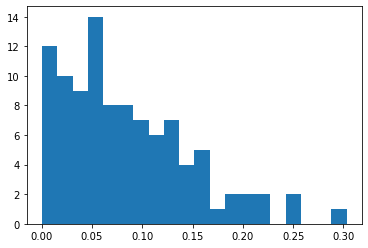

In [23]:
plt.hist(v_abs,20)